# 시각화 테스트

# 1. 라이브러리 로드 및 함수/클래스 정의

In [14]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import augraphy as aug
import matplotlib.pyplot as plt
import random

# --- 1. (필수) 학습 코드에서 사용한 모든 함수/클래스 정의 ---
# (Augraphy 파이프라인, 3종류의 get_train_transform, 
#  get_valid_transform, 3단계 DocumentDataset 클래스)

# 1.1 Augraphy 파이프라인 (표준, 강력한)
augraphy_pipeline = aug.AugraphyPipeline([
    aug.BadPhotoCopy(noise_size=(1, 3), noise_value=(50, 100), p=0.5),
    aug.LowInkRandomLines(count_range=(3, 10), use_consistent_lines=False, p=0.4),
    aug.DirtyRollers(line_width_range=(2, 6), p=0.3),
])
augraphy_pipeline_hard = aug.AugraphyPipeline([
    aug.BadPhotoCopy(noise_size=(2, 5), noise_value=(40, 80), p=0.8),
    aug.LowInkRandomLines(count_range=(5, 15), use_consistent_lines=False, p=0.7),
    aug.DirtyRollers(line_width_range=(3, 8), p=0.6),
])
def apply_augraphy(image, **kwargs):
    return augraphy_pipeline.augment(image)["output"]
def apply_augraphy_hard(image, **kwargs):
    return augraphy_pipeline_hard.augment(image)["output"]

# 1.2 Transform 함수 (3종류 + Valid)
def get_train_transform_hard_paper(img_size): # '어려운' 종이
    return A.Compose([
        A.Lambda(image=apply_augraphy_hard, p=0.8),
        A.Perspective(scale=(0.05, 0.1), pad_mode=cv2.BORDER_CONSTANT, p=0.7),
        A.Rotate(limit=(-30, 30), border_mode=cv2.BORDER_CONSTANT, value=0, p=0.8),
        A.MotionBlur(blur_limit=(3, 9), p=0.5),
        A.GaussianBlur(blur_limit=(3, 9), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.HorizontalFlip(p=0.5),
        ToTensorV2()
    ])
def get_train_transform(img_size): # '쉬운' 종이 (기존)
    return A.Compose([
        A.Lambda(image=apply_augraphy, p=0.3), # p=0.5 -> 0.3
        A.Perspective(scale=(0.02, 0.05), pad_mode=cv2.BORDER_CONSTANT, p=0.4), # scale (0.05, 0.1) -> (0.02, 0.05), p=0.7 -> 0.4
        A.Rotate(limit=(-20, 20), border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5), # limit (-40, 40) -> (-20, 20), p=0.8 -> 0.5
        A.HorizontalFlip(p=0.2), # p=0.5 -> 0.2
        A.MotionBlur(blur_limit=(3, 7), p=0.2), # limit (3, 11) -> (3, 7), p=0.4 -> 0.2
        A.GaussianBlur(blur_limit=(3, 5), p=0.2), # limit (3, 7) -> (3, 5), p=0.4 -> 0.2
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3), # limit 0.2 -> 0.1, p=0.5 -> 0.3
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.HorizontalFlip(p=0.5),
        ToTensorV2()
    ])
def get_train_transform_non_paper(img_size): # '비종이'
    return A.Compose([
        A.Perspective(scale=(0.05, 0.1), pad_mode=cv2.BORDER_CONSTANT, p=0.7),
        A.Rotate(limit=(-30, 30), border_mode=cv2.BORDER_CONSTANT, value=0, p=0.8),
        A.MotionBlur(blur_limit=(3, 11), p=0.4),
        A.GaussianBlur(blur_limit=(3, 7), p=0.4),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.HorizontalFlip(p=0.5),
        ToTensorV2()
    ])
def get_valid_transform(img_size): # 검증용 (증강 없음)
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

In [ ]:
# ============================
# DocumentDataset 클래스
# ============================
class DocumentDataset(Dataset):
    def __init__(self, df, img_dir, 
                 hard_paper_transform=None,
                 easy_paper_transform=None, 
                 non_paper_transform=None):
        self.img_dir = img_dir
        self.hard_paper_transform = hard_paper_transform
        self.easy_paper_transform = easy_paper_transform
        self.non_paper_transform = non_paper_transform
        self.hard_paper_targets = {3, 4, 6, 7, 14, 10}
        self.easy_paper_targets = {1, 11, 12, 13}
        df_reset = df.reset_index(drop=True)
        self.image_ids = df_reset['ID'].values
        self.labels = df_reset['target'].values
        self.length = len(df_reset)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        label = self.labels[idx]
        img_path = os.path.join(self.img_dir, img_id)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        transform_to_apply = None
        if label in self.hard_paper_targets:
            transform_to_apply = self.hard_paper_transform
        elif label in self.easy_paper_targets:
            transform_to_apply = self.easy_paper_transform
        else:
            transform_to_apply = self.non_paper_transform
        
        if transform_to_apply:
            augmented = transform_to_apply(image=image)
            image = augmented['image']
            
        return image, label

In [ ]:
# ============================
# 시각화 함수 정의
# ============================
def unnormalize(tensor_img):
    """
    Pytorch 텐서 (C, H, W)를 Matplotlib용 (H, W, C) numpy 이미지로 변환
    """
    # ImageNet 정규화 표준값
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # (C, H, W) -> (H, W, C)
    img_np = tensor_img.numpy().transpose(1, 2, 0)
    
    # Un-normalize
    img_np = std * img_np + mean
    
    # 값 범위를 [0, 1]로 클리핑
    img_np = np.clip(img_np, 0, 1)
    
    return img_np

def show_augmented_samples(aug_dataset, orig_dataset, indices, group_title):
    """
    특정 인덱스의 원본(Before)과 증강(After) 이미지를 비교 출력
    """
    print(f"\n--- {group_title} 샘플 ---")
    
    for idx in indices:
        img_aug, label = aug_dataset[idx]
        img_orig, _ = orig_dataset[idx]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        ax1.imshow(unnormalize(img_orig))
        ax1.set_title(f"Original (Label: {label}, Index: {idx})")
        ax1.axis('off')
        
        ax2.imshow(unnormalize(img_aug))
        ax2.set_title(f"Augmented (Group: {group_title})")
        ax2.axis('off')
        
        plt.show()

# 2. 시각화 실행


--- '어려운 종이' (Hard Augmentation) 샘플 ---


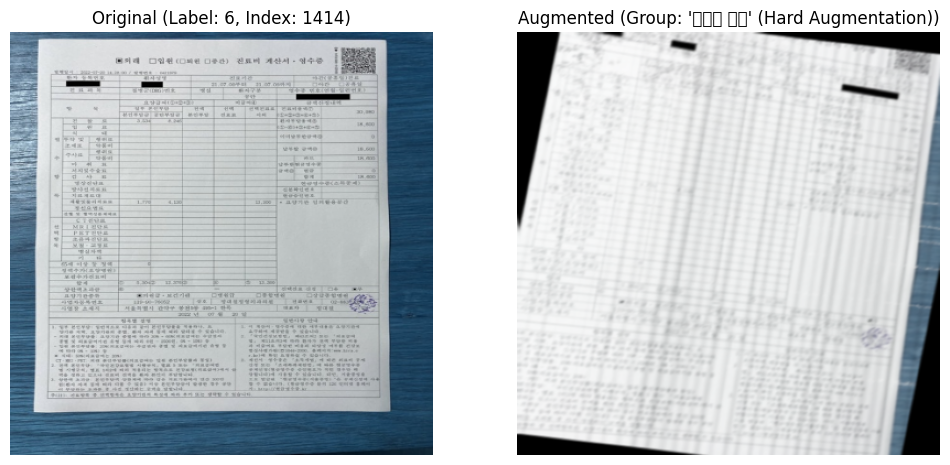


--- '쉬운 종이' (Standard Augmentation) 샘플 ---


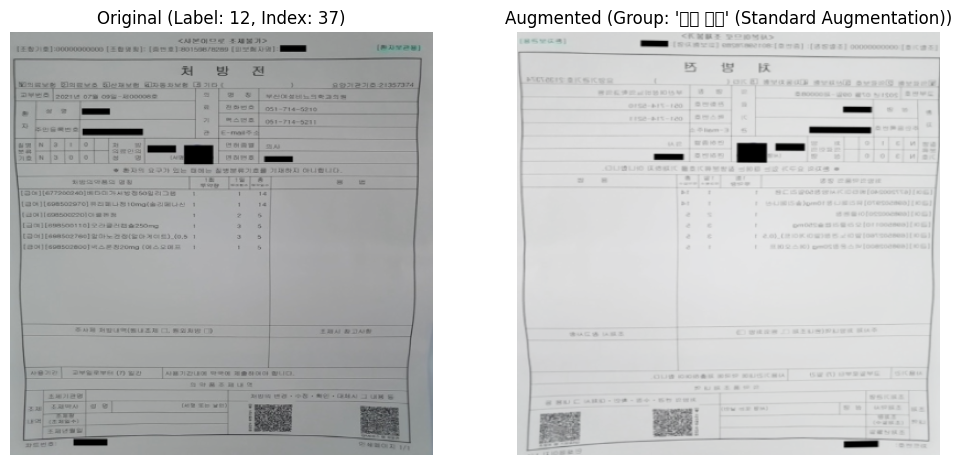


--- '비종이' (No Augraphy) 샘플 ---


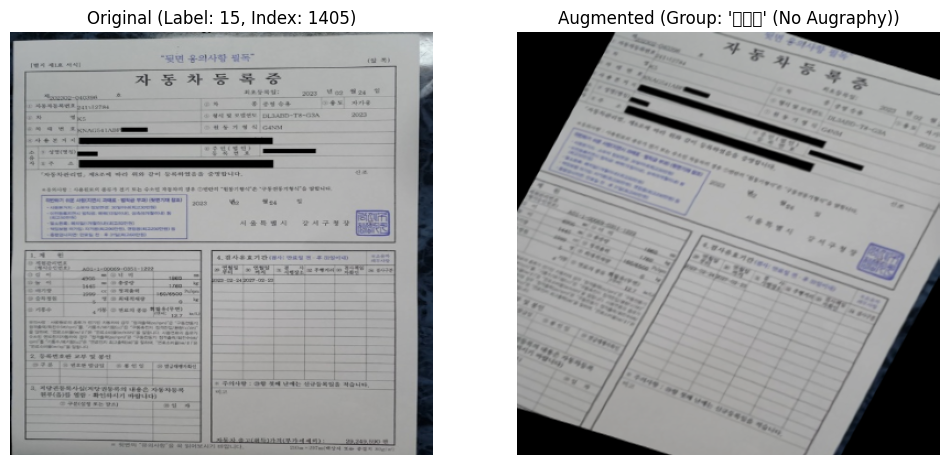

In [17]:
IMG_SIZE = 384
TRAIN_IMG_DIR = "datasets_fin/train/"
TRAIN_CSV_PATH = "datasets_fin/train.csv"
N_SAMPLES_PER_GROUP = 1 # 그룹당 2개 샘플 확인
# --- (설정 끝) ---

# 1. 전체 데이터 로드
df = pd.read_csv(TRAIN_CSV_PATH)

# 2. 4가지 Transform 정의
hard_paper_transform = get_train_transform_hard_paper(IMG_SIZE)
easy_paper_transform = get_train_transform(IMG_SIZE)
non_paper_transform = get_train_transform_non_paper(IMG_SIZE)
valid_transform = get_valid_transform(IMG_SIZE)

# 3. Dataset 2개 생성
# 3.1 증강(After) 데이터셋
aug_dataset = DocumentDataset(
    df, TRAIN_IMG_DIR, 
    hard_paper_transform=hard_paper_transform,
    easy_paper_transform=easy_paper_transform,
    non_paper_transform=non_paper_transform
)
# 3.2 원본(Before) 데이터셋
orig_dataset = DocumentDataset(
    df, TRAIN_IMG_DIR,
    hard_paper_transform=valid_transform, # (모두 valid_transform 사용)
    easy_paper_transform=valid_transform,
    non_paper_transform=valid_transform
)

# 4. 각 그룹별 인덱스 찾기
hard_targets = {3, 4, 6, 7, 14, 10}
easy_targets = {1, 11, 12, 13}

indices_hard = df[df['target'].isin(hard_targets)].index
indices_easy = df[df['target'].isin(easy_targets)].index
indices_non_paper = df[~df['target'].isin(hard_targets | easy_targets)].index

# 5. 그룹별 랜덤 샘플 시각화
show_augmented_samples(
    aug_dataset, orig_dataset, 
    random.sample(list(indices_hard), N_SAMPLES_PER_GROUP), 
    "'어려운 종이' (Hard Augmentation)"
)

show_augmented_samples(
    aug_dataset, orig_dataset, 
    random.sample(list(indices_easy), N_SAMPLES_PER_GROUP), 
    "'쉬운 종이' (Standard Augmentation)"
)

show_augmented_samples(
    aug_dataset, orig_dataset, 
    random.sample(list(indices_non_paper), N_SAMPLES_PER_GROUP), 
    "'비종이' (No Augraphy)"
)